In [169]:
import os
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler,StandardScaler
#ElasticNet
from sklearn.linear_model import ElasticNet
#Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


In [ ]:
os.chdir('..')

In [288]:
DATA_PATH = os.path.join('research\Green Chilly Prices 21-25.csv')
chilly_data = pd.read_csv(DATA_PATH)

In [289]:
chilly_data.head()

,date,temp,precip,humidity,windspeed,cloudcover,dew,yesterday,today
0,2021/01/01,25.0,6.778,83.6,17.3,76.7,21.8,395.0,325.0
1,2021/01/04,25.0,16.828,93.3,13.7,95.0,23.8,325.0,365.0
2,2021/01/05,25.5,5.183,89.8,10.4,83.9,23.6,365.0,330.0
3,2021/01/06,26.0,7.048,87.5,6.5,77.9,23.6,330.0,295.0
4,2021/01/07,26.2,30.440,86.2,10.8,78.4,23.5,295.0,365.0


In [290]:

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import numpy as np
chilly_data.date = pd.to_datetime(chilly_data.date)
chilly_data['day'] = chilly_data.date.dt.day
chilly_data['month'] = chilly_data.date.dt.month
chilly_data['year'] = chilly_data.date.dt.year
chilly_data['day_of_week'] = chilly_data.date.dt.dayofweek

def evaluate_model(y_act,y_pred):
    rmse = np.sqrt(mean_squared_error(y_act,y_pred))
    mae = mean_absolute_error(y_act,y_pred)
    r2 = r2_score(y_act,y_pred)
    return rmse,mae,r2

In [346]:
from xgboost import XGBRegressor
chilly_data = pd.read_csv(DATA_PATH)

chilly_data = chilly_data.drop(columns=['temp', 'humidity', 'windspeed', 'cloudcover', 'dew'])


# chilly_data['date'] = pd.to_datetime(chilly_data['date'])
# chilly_data['day'] = chilly_data.date.dt.day
# chilly_data['month'] = chilly_data.date.dt.month
# chilly_data['year'] = chilly_data.date.dt.year
# chilly_data['day_of_week'] = chilly_data.date.dt.dayofweek
# chilly_data['is_weekend'] = chilly_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
# chilly_data['price_2_days_ago'] = chilly_data['today'].shift(2)
# # chilly_data['temp_7_days_avg'] = chilly_data['temp'].rolling(7).mean()

chilly_data['date'] = pd.to_datetime(chilly_data['date'])
chilly_data.set_index('date', inplace=True)
chilly_data = chilly_data.asfreq('D')
# chilly_data['last_months_precip_avg'] = chilly_data['precip'].rolling(window=30, min_periods=1).mean()
chilly_data['last_2_months_precip_avg'] = chilly_data['precip'].rolling(window=60, min_periods=1).mean()
chilly_data['last_3_months_precip_avg'] = chilly_data['precip'].rolling(window=90, min_periods=1).mean()
# chilly_data['price_3day_avg'] = chilly_data['today'].rolling(3).mean()
chilly_data.dropna(inplace=True)
# Resample by week and calculate mean
chilly_data = chilly_data.resample('W').mean()
chilly_data['date'] = chilly_data.index
chilly_data['month'] = chilly_data.index.month
chilly_data['year'] = chilly_data.index.year

chilly_data['month'] = chilly_data['date'].dt.month
chilly_data = pd.get_dummies(chilly_data, columns=['month'], drop_first=False)
print(chilly_data.columns)

chilly_data['month'] = chilly_data.index.month


monthly_precip = chilly_data.groupby(['year', 'month'])['today'].mean().reset_index()
monthly_precip.rename(columns={'today': 'previous_year_current_month_avg'}, inplace=True)

chilly_data = pd.merge(
    chilly_data,
    monthly_precip,
    on=['year', 'month'],
    how='left'
)

chilly_data.dropna(inplace=True)

train_split = 4 * 2 # Assuming 4 weeks in a month, adjust as needed
train = chilly_data[:-train_split]
test = pd.DataFrame(chilly_data[-train_split:],index=None)

scaler = StandardScaler()
train_x = train.drop(columns=[ 'date','today','precip','month'])
train_y = train['today']
train_x_scaled = scaler.fit_transform(train_x)

ls_scaler = MinMaxScaler()
scaled_data = ls_scaler.fit_transform(train.drop(columns=['date']))
scaled_data_df = pd.DataFrame(scaled_data,columns=train.drop(columns=['date']).columns)
X_all = scaled_data_df.drop(columns=['today'])
y_all = scaled_data_df.today

def train_and_evaluate(model):
    m_test = chilly_data[-train_split:]
    m_test_scaled = scaler.transform(m_test.drop(columns=['date','today','precip','month']))
    print(f"Training model: {model.__class__.__name__}")
    model.fit(train_x_scaled, train['today'])
    pred = model.predict(m_test_scaled)
    print(f"Model evaluation: {evaluate_model(m_test['today'], pred)}")
    print(pred[-3:])
    print(m_test['today'][-3:])
    
    
def create_sequences(X, y, seq_len=30):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

sequence_length = 30
X, y = create_sequences(X_all, y_all, sequence_length)

Index(['precip', 'yesterday', 'today', 'last_2_months_precip_avg',
       'last_3_months_precip_avg', 'date', 'year', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')


In [347]:
xg_model = XGBRegressor(
    n_estimators=70,
    learning_rate=0.5
)

rf_model = RandomForestRegressor(
    n_estimators=40
)

lr_model = LinearRegression()

poly_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)

knn_model = KNeighborsRegressor(n_neighbors=5)
el_model = ElasticNet(
    alpha=0.1,
    l1_ratio=0.01,
    random_state=42
)

train_and_evaluate(xg_model)
train_and_evaluate(rf_model)
train_and_evaluate(lr_model)
train_and_evaluate(knn_model)
train_and_evaluate(el_model)
train_and_evaluate(poly_model)

Training model: XGBRegressor
Model evaluation: (43.29574367887901, 35.67767651875814, 0.9013473216826593)
[499.522   497.52097 407.0697 ]
233    482.0
234    512.0
235    410.0
Name: today, dtype: float64
Training model: RandomForestRegressor
Model evaluation: (45.42715910932497, 34.12401041666668, 0.8913950477633987)
[489.44791667 484.21041667 405.95416667]
233    482.0
234    512.0
235    410.0
Name: today, dtype: float64
Training model: LinearRegression
Model evaluation: (31.64273066320948, 26.52689915117945, 0.9473053672555674)
[518.81164722 516.16011932 435.48248195]
233    482.0
234    512.0
235    410.0
Name: today, dtype: float64
Training model: KNeighborsRegressor
Model evaluation: (106.22930223237739, 92.84166666666667, 0.4061084714147698)
[397.9        397.9        389.93333333]
233    482.0
234    512.0
235    410.0
Name: today, dtype: float64
Training model: ElasticNet
Model evaluation: (33.4704878240962, 26.68322524370417, 0.9410420252091892)
[505.6857023  503.61558805 43

In [212]:

lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    LSTM(64),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse',metrics=['mae'])
lstm_train_x,lstm_train_y = X[:-35], y[:-35]
lstm_val_x, lstm_val_y = X[-35:], y[-35:]
lstm_model.fit(lstm_train_x, lstm_train_y, epochs=5, batch_size=32, validation_data=(lstm_val_x, lstm_val_y), verbose=1)


# Predict
pred_scaled = lstm_model.predict(lstm_val_x)
print(pred_scaled[-3:])

# For inverse transformation, we need to reconstruct the full feature set
# The LSTM model predicts only the 'today' price (scaled), but we need all features for inverse transform

# Get the last time step features from validation data
last_features = lstm_val_x[:, -1, :]  # Shape: (35, 7) - features except 'today'

# Insert the predicted 'today' values at the correct position
# According to ls_scaler.feature_names_in_, 'today' is at index 2
full_features = np.zeros((pred_scaled.shape[0], ls_scaler.n_features_in_))
full_features[:, :2] = last_features[:, :2]  # precip, yesterday
full_features[:, 2] = pred_scaled.reshape(-1)  # today (predicted)
full_features[:, 3:] = last_features[:, 2:]  # remaining features

# Now use ls_scaler for inverse transformation
predicted_prices = ls_scaler.inverse_transform(full_features)[:, 2]  # Extract 'today' column

# Get actual unscaled prices for proper comparison
actual_test_data = chilly_data[-35:]
actual_prices = actual_test_data['today'].values

print(f"Predicted prices (last 3): {predicted_prices[-3:]}")
print(f"Actual prices (last 3): {actual_prices[-3:]}")

# Evaluate LSTM model with correct actual values
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)
print(f"LSTM Model evaluation - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Epoch 1/5


c:\Users\Hasinthaka Piyumal\.conda\envs\mlops\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.5285 - mae: 0.6881 - val_loss: 0.0361 - val_mae: 0.1353
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.5285 - mae: 0.6881 - val_loss: 0.0361 - val_mae: 0.1353
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.2749 - mae: 0.4829 - val_loss: 0.0276 - val_mae: 0.1301
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.2749 - mae: 0.4829 - val_loss: 0.0276 - val_mae: 0.1301
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.1155 - mae: 0.2874 - val_loss: 0.0718 - val_mae: 0.2350
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.1155 - mae: 0.2874 - val_loss: 0.0718 - val_mae: 0.2350
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.0363 - mae: 0.1443 - val_loss: 0.1738 - val_mae: 0.3776
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.0363 - mae: 0.1443 - val_loss: 0.1738 - val_mae: 0.3776
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.0458 - mae: 0.1807 - val_loss: 0.2470

In [360]:
from datetime import timedelta

# test_frame = pd.DataFrame(columns=[
#     'date',
#     # 'temp', 'precip', 'humidity', 'windspeed', 'cloudcover', 'dew',
#     'yesterday', 'today', 
#     # 'day', 'month', 'year', 'day_of_week',
#     # 'is_weekend', 'price_10day_avg'
#     # 'is_weekend', 'price_2_days_ago', 'price_3day_avg'
# ])
test_frame = pd.DataFrame(columns=chilly_data.columns)
# test_frame = pd.DataFrame(columns=[
#     'date',
#     # 'precip',
#     'yesterday', 'today', 
#     # 'last_months_precip_avg',
#     'last_2_months_precip_avg', 'last_3_months_precip_avg', 
#     # 'month',
#     'previous_year_current_month_avg',
#     # 'price_3day_avg',
#     'year'
# ])

# Start with last 3 known rows (for lag features)
test_frame = train.iloc[-12:].copy()

# Forecast target
predicting_date = pd.to_datetime('2025-06-30')
current_date = pd.to_datetime(test_frame.iloc[-1]['date'])

monthly_precip[monthly_precip['year'] == 2025]

# Loop to predict and fill future rows
while current_date < predicting_date:
    current_date += timedelta(days=7)
    index = len(test_frame)-12
    print(f"Predicting for date: {current_date.strftime('%Y-%m-%d')} (Index: {index})")
    # Use latest known or assumed weather values
    last_known = test.iloc[index]

    # Lag prices
    yesterday = test_frame.iloc[-1]['today']
    # price_2_days_ago = test_frame.iloc[-2]['today']
    price_3day_avg = test_frame['today'].iloc[-3:].mean()
    last_months_precip_avg = test_frame['precip'].iloc[-4:].mean()
    last_3_months_precip_avg = test_frame['precip'].iloc[-12:].mean()
    last_2_months_precip_avg = test_frame['precip'].iloc[-8:].mean()
    
    # Prepare input
    row = {
        'date': current_date,
        # 'temp': last_known['temp'],
        # 'precip': last_known['precip'],
        # 'humidity': last_known['humidity'],
        # 'windspeed': last_known['windspeed'],
        # 'cloudcover': last_known['cloudcover'],
        # 'dew': last_known['dew'],
        'yesterday': yesterday,
        # 'day': current_date.day,
        # 'last_months_precip_avg': last_months_precip_avg,
        'last_2_months_precip_avg': last_2_months_precip_avg,
        'last_3_months_precip_avg': last_3_months_precip_avg,
        # 'price_3day_avg': price_3day_avg,
        'month': current_date.month,
        'year': current_date.year,
        # 'day_of_week': current_date.weekday(),
        # 'is_weekend': int(current_date.weekday() >= 5),
        # 'price_2_days_ago': price_2_days_ago,
        'previous_year_current_month_avg': monthly_precip[(monthly_precip['year'] == current_date.year-1) & (monthly_precip['month'] == current_date.month)]['previous_year_current_month_avg'].values[0]
    }
    
    for i in range(1, 13):
        month_col = f'month_{i}'
        if month_col in test_frame.columns:
            row[month_col] = 1 if i == current_date.month else 0
        else:
            row[month_col] = 0

    # Convert to DataFrame for prediction
    row_df = pd.DataFrame([row],columns=test_frame.drop(columns=['precip','today']).columns)
     
    # Predict future price
    scaled_row = scaler.transform(row_df.drop(columns=['date','month']))
    row['today'] = rf_model.predict(scaled_row)[0]


    # Append to test_frame
    test_frame = pd.concat([test_frame, pd.DataFrame([row])])
    

# Display final forecasted frame
print(test_frame.shape)
print(len(test_frame[12:]))
print(len(test[:25]))
print(test_frame[12:]['date'].values)
print(test['date'].values)
print(evaluate_model(test_frame[12:]['today'], test['today']))
rf_val = test_frame

Predicting for date: 2025-05-18 (Index: 0)
Predicting for date: 2025-05-25 (Index: 1)
Predicting for date: 2025-06-01 (Index: 2)
Predicting for date: 2025-06-08 (Index: 3)
Predicting for date: 2025-06-15 (Index: 4)
Predicting for date: 2025-06-22 (Index: 5)
Predicting for date: 2025-06-29 (Index: 6)
Predicting for date: 2025-07-06 (Index: 7)
(20, 21)
8
8
['2025-05-18T00:00:00.000000000' '2025-05-25T00:00:00.000000000'
 '2025-06-01T00:00:00.000000000' '2025-06-08T00:00:00.000000000'
 '2025-06-15T00:00:00.000000000' '2025-06-22T00:00:00.000000000'
 '2025-06-29T00:00:00.000000000' '2025-07-06T00:00:00.000000000']
['2025-05-18T00:00:00.000000000' '2025-05-25T00:00:00.000000000'
 '2025-06-01T00:00:00.000000000' '2025-06-08T00:00:00.000000000'
 '2025-06-15T00:00:00.000000000' '2025-06-22T00:00:00.000000000'
 '2025-06-29T00:00:00.000000000' '2025-07-06T00:00:00.000000000']
(302.36213396799917, 273.3963541666667, -638.0271057513708)


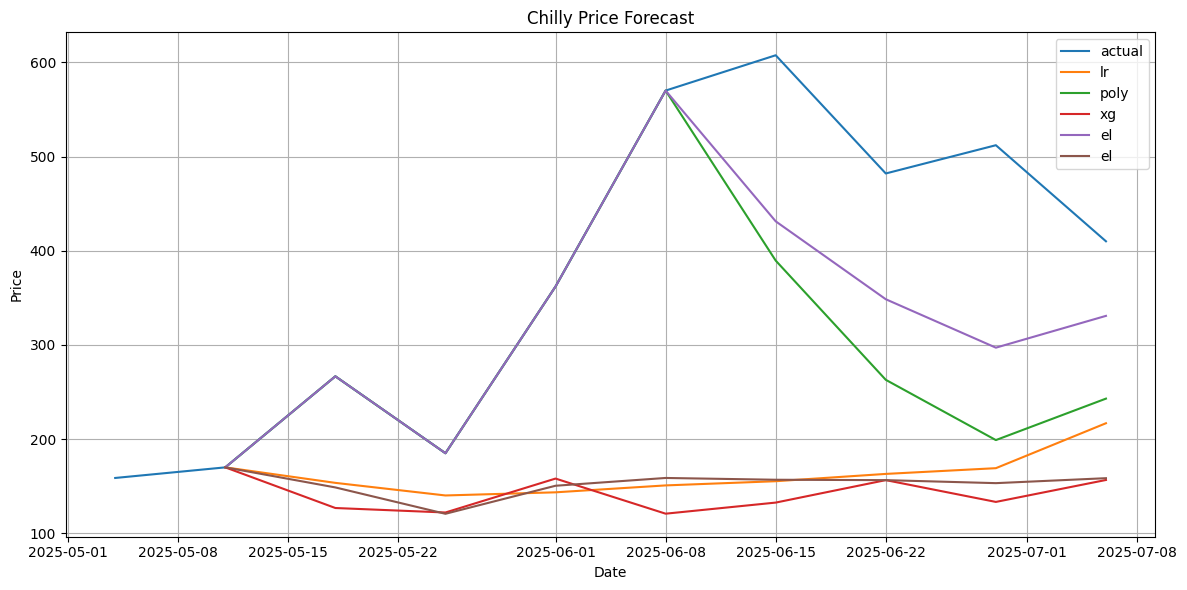

In [358]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Plot full prediction
plt.plot(chilly_data[-10:]['date'], chilly_data[-10:]['today'], label='actual')
train_split+=1
# Plot only from index 90
plt.plot(lr_val[-train_split:]['date'], lr_val[-train_split:]['today'], label='lr')
plt.plot(poly_val[-train_split:]['date'], poly_val[-train_split:]['today'], label='poly')
plt.plot(xg_val[-train_split:]['date'], xg_val[-train_split:]['today'], label='xg')
plt.plot(el_val[-train_split:]['date'], el_val[-train_split:]['today'], label='el')
plt.plot(rf_val[-train_split:]['date'], rf_val[-train_split:]['today'], label='el')

plt.title('Chilly Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [204]:
# Sample: daily price data
df = pd.read_csv(DATA_PATH)

df.precip = df.precip * 10

# Ensure 'date' is a datetime object and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.asfreq('D')
df['last_months_precip_avg'] = df['precip'].rolling(window=30, min_periods=1).mean()
df['last_2_months_precip_avg'] = df['precip'].rolling(window=60, min_periods=1).mean()
df['last_3_months_precip_avg'] = df['precip'].rolling(window=90, min_periods=1).mean()
print(df.head())
df.dropna(inplace=True)
# Resample by week and calculate mean
weekly_avg = df.resample('W').mean()
print(df)
print(weekly_avg)

            temp  precip  humidity  windspeed  cloudcover   dew  yesterday  \
date                                                                         
2023-01-05  25.6     1.0      84.3       18.4        56.5  22.7      260.0   
2023-01-06   NaN     NaN       NaN        NaN         NaN   NaN        NaN   
2023-01-07   NaN     NaN       NaN        NaN         NaN   NaN        NaN   
2023-01-08   NaN     NaN       NaN        NaN         NaN   NaN        NaN   
2023-01-09   NaN     NaN       NaN        NaN         NaN   NaN        NaN   

            today  last_months_precip_avg  last_2_months_precip_avg  \
date                                                                  
2023-01-05  270.0                     1.0                       1.0   
2023-01-06    NaN                     1.0                       1.0   
2023-01-07    NaN                     1.0                       1.0   
2023-01-08    NaN                     1.0                       1.0   
2023-01-09    NaN          

<Axes: title={'center': 'Chilly Price Forecast'}, xlabel='date'>

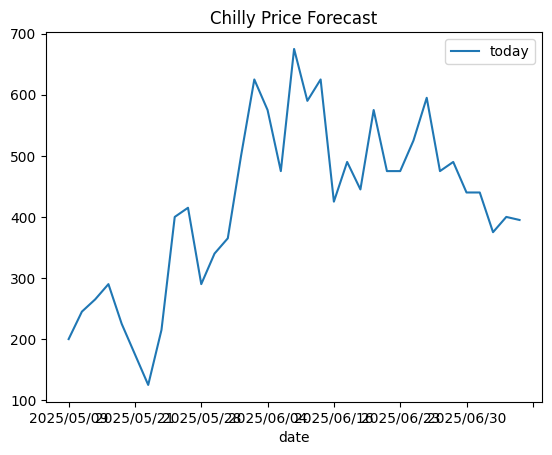

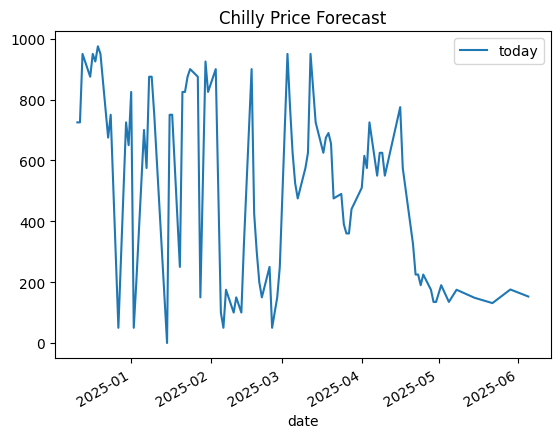

In [76]:
test.plot(x='date', y='today', kind='line', title='Chilly Price Forecast')
test_frame.plot(x='date', y='today', kind='line', title='Chilly Price Forecast')

<Axes: title={'center': 'Weekly Average Price of Green Chilly'}, xlabel='date'>

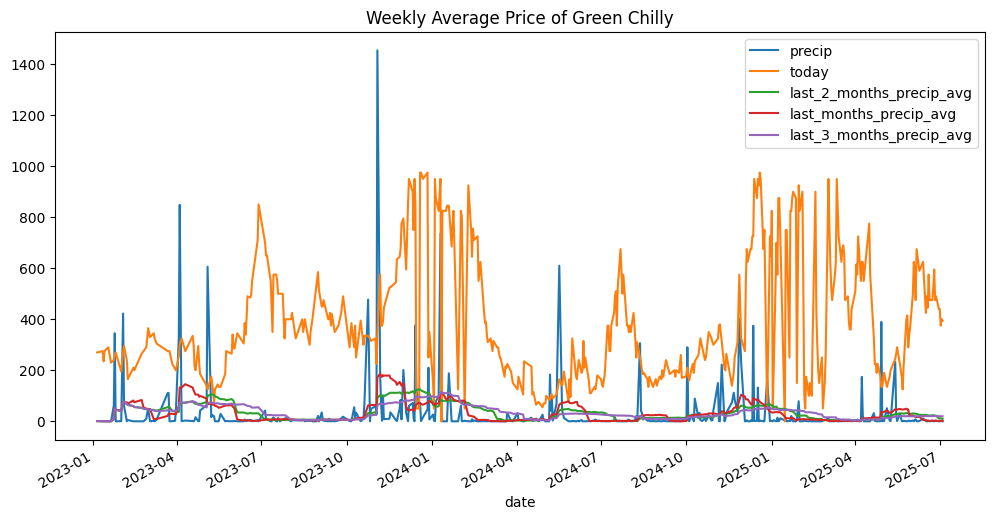

In [45]:
df[['precip', 'today', 'last_2_months_precip_avg','last_months_precip_avg','last_3_months_precip_avg']].plot(figsize=(12, 6), title='Weekly Average Price of Green Chilly')

In [189]:
# Summary of data shapes and scalers
print("Data shapes:")
print(f"LSTM validation input: {lstm_val_x.shape}")
print(f"LSTM predictions: {pred_scaled.shape}")

print(f"\nScaler configurations:")
print(f"scaler features ({scaler.n_features_in_}): {list(scaler.feature_names_in_)}")
print(f"ls_scaler features ({ls_scaler.n_features_in_}): {list(ls_scaler.feature_names_in_)}")
print("Note: LSTM uses ls_scaler for proper inverse transformation")

Data shapes:
LSTM validation input: (35, 30, 8)
LSTM predictions: (35, 1)

Scaler configurations:
scaler features (8): ['precip', 'yesterday', 'last_months_precip_avg', 'last_2_months_precip_avg', 'last_3_months_precip_avg', 'price_3day_avg', 'month', 'year']
ls_scaler features (9): ['precip', 'yesterday', 'today', 'last_months_precip_avg', 'last_2_months_precip_avg', 'last_3_months_precip_avg', 'price_3day_avg', 'month', 'year']
Note: LSTM uses ls_scaler for proper inverse transformation


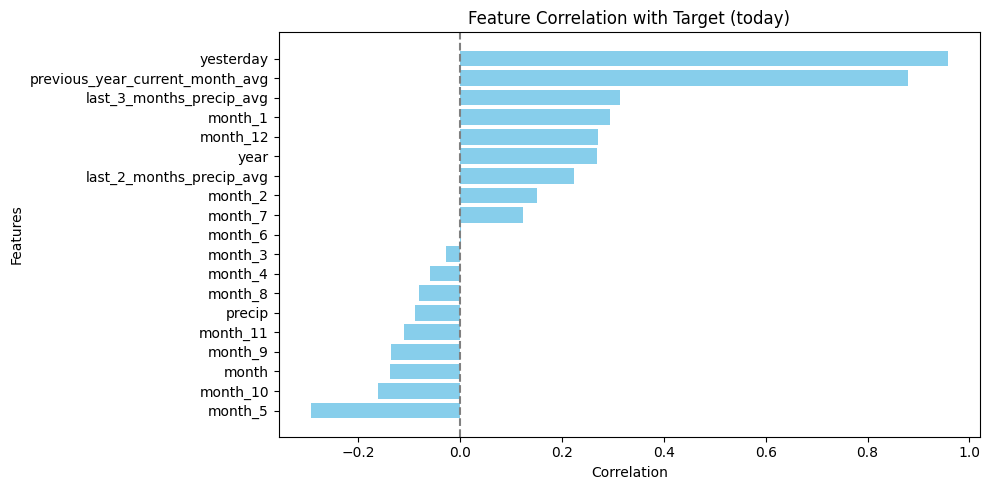

In [361]:
import matplotlib.pyplot as plt

# Calculate correlation with 'today'
correlations = chilly_data.corr(numeric_only=True)['today'].sort_values()

# Drop the target itself if needed
correlations = correlations.drop('today')

# Plot using plt
plt.figure(figsize=(10, 5))
plt.barh(correlations.index, correlations.values, color='skyblue')
plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Feature Correlation with Target (today)')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


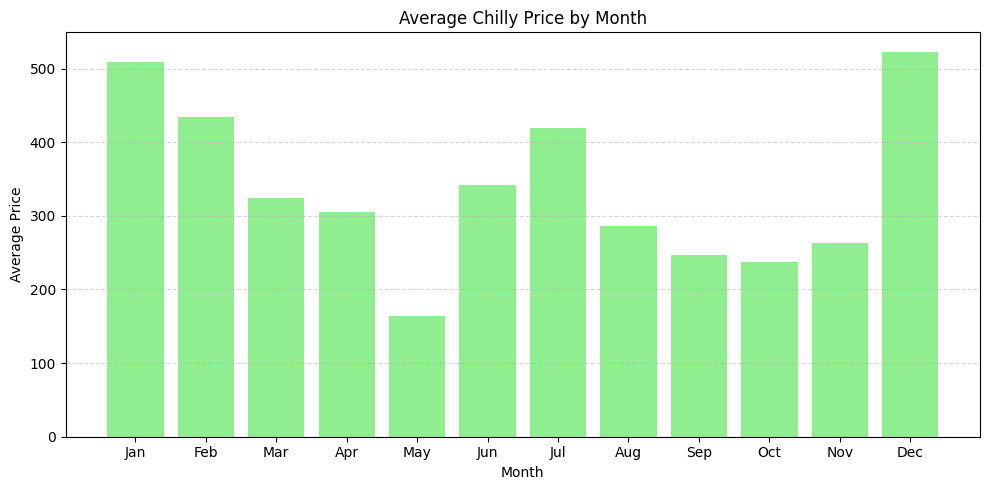

In [343]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'date' column is datetime and set as index if not already
chilly_data = chilly_data.reset_index()
chilly_data['month'] = chilly_data['date'].dt.month
chilly_data['year'] = chilly_data['date'].dt.year  # Optional

# Group by month and calculate average price
monthly_avg = chilly_data.groupby('month')['today'].mean()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(monthly_avg.index, monthly_avg.values, color='lightgreen')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Average Chilly Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
